In [3]:
%pip install transformers 
%pip install sklearn
%pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#from sklearn.datasets import fetch_20newsgroups #encountered issues SSLCertificationError with this 
from datasets import load_dataset, load_metric
import os
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding,get_scheduler
from torch.optim import AdamW

from spacy import tokenizer
from spacy.lang.en import English
import torch
from torch.utils.data import DataLoader
from utils import RoBERT_Model,ToBERT_Model
import json
import matplotlib.pyplot as plt

In [5]:
from utils import AssessData

In [6]:
accuracy = load_metric('accuracy'); f1_score = load_metric('f1'); perplexity = load_metric('perplexity')

In [7]:
hyperpartisan_dataset = load_dataset("hyperpartisan_news_detection", "bypublisher") #Not stripped of headers and footers
hyperpartisan_dataset.keys()

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/600000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/600000 [00:00<?, ? examples/s]

Dataset hyperpartisan_news_detection downloaded and prepared to /root/.cache/huggingface/datasets/hyperpartisan_news_detection/bypublisher/1.0.0/7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

dict_keys(['train', 'validation'])

In [8]:
#change to bypublisher because byarticle has no test set.
hyperpartisan_train = hyperpartisan_dataset['train']
hyperpartisan_valid = hyperpartisan_dataset['validation']

hyperpartisan_train = hyperpartisan_train.shuffle(seed = 32)
hyperpartisan_test = hyperpartisan_valid.shuffle(seed = 32)

With huggingface

DOCUMENTS LESS THAN 300

In [9]:
#Should work once then modularize

max_input_length = 300 #Vary after obtaining end to end result
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, max_length = max_input_length)
overlap = {"side":"both", "number": 100}; f1_score = load_metric("f1"); precision = load_metric("precision"); recall = load_metric("recall")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer) #to pad sequences


def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, max_length=max_input_length)

def compute_metrics(eval_pred):
    predictions, label = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    return {"f1" :f1_score.compute(predictions = predictions, references = label, average = 'weighted'),
            "precision" : precision.compute(predictions = predictions, references = label, average = 'weighted'),
            "recall": recall.compute(predictions = predictions, references = label, average = 'weighted')}

def hp_space(trial):

  return {"per_device_train_batch_size": trial.suggest_discrete_uniform("per_device_train_batch_size", 8,32,8)
        ,"learning_rate": trial.suggest_float("learning_rate", 0.0001,0.0005, log = True)
        ,"num_train_epochs": trial.suggest_int("num_train_epochs",1,10)
  }

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [10]:
hyperpartisan_train = hyperpartisan_train.select(range(2000)) #inconclusive because of nature of dataset
hyperpartisan_test = hyperpartisan_test.select(range(2000))

In [11]:
int_labels_train = {i: 1 if x == True else 0 for i,x in enumerate(hyperpartisan_train['hyperpartisan'])}
int_labels_test = {i: 1 if x == True else 0 for i,x in enumerate(hyperpartisan_test['hyperpartisan'])}

In [12]:
hyperpartisan_train = hyperpartisan_train.map(tokenize)
hyperpartisan_test = hyperpartisan_test.map(tokenize)

  0%|          | 0/2000 [00:00<?, ?ex/s]

  0%|          | 0/2000 [00:00<?, ?ex/s]

EFFECT OF FINETUNING (with varying number of training files)

In [13]:
hyp_train = {i:x for i,x in enumerate(hyperpartisan_train['text'])}
hyp_test = {i:x for i,x in enumerate(hyperpartisan_test['text'])}

In [14]:
hyperpartisan_train = hyperpartisan_train.add_column("labels", int_labels_train.values())
hyperpartisan_test = hyperpartisan_test.add_column("labels", int_labels_test.values())

In [15]:
#Problems with finetuning with limited number of training files, is training set is unbalanced
#Less knowledge for neural network to learn from 
#Why not investigate the definition of what a chunk is, and use different pretraining objective e.g BERT,Roberta
#Problem with finetuning with long document is document input are limited in length, therefore learning across text documents is unbalanced

#Only way around finetuning on text document is to carefully analyse the training set and long documents.

(array([ 988.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1012.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

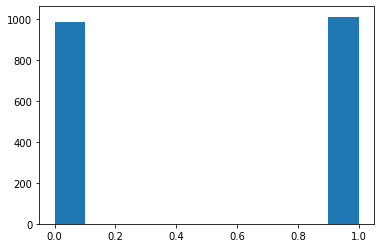

In [16]:
#Insight into the distribution of the dataset
plt.hist(hyperpartisan_train['labels'])

In [17]:
from sklearn.model_selection import KFold

In [18]:
hyp_train = AssessData(hyp_train, dict())
hyp_test = AssessData(hyp_test, dict())

In [19]:
number = range(50,150,50); _per_segment = range(200,400,100); max_input_length = 300

overlap = {"side":"both", "number": 100}

In [20]:
train_set = hyp_train._chunk(200, overlap=overlap)
train_index, train_text = zip(*train_set)

#Creates dictionary for train_index and train_text
train_index = {a:x for a,x in enumerate(train_index)}
train_text = {a:x for a,x in enumerate(train_text)}

In [21]:
test_set = hyp_test._chunk(200, overlap=overlap)
test_index, test_text = zip(*test_set)

#Creates dictionary for test_index and test_text

test_index = {a:x for a,x in enumerate(test_index)}
test_text = {a:x for a,x in enumerate(test_text)}

In [22]:
#Creates dictionary of labels
train_chunked_label = {i:hyperpartisan_train['labels'][x] for i,x in train_index.items()}

In [23]:
test_chunked_label = {i:hyperpartisan_test['labels'][x] for i,x in test_index.items()}

In [24]:
train_set = {"train" : {"text": train_text.values(), "doc_id": train_index.values(), "labels": train_chunked_label.values()}}
test_set =  {"test" : {"text": test_text.values(), 'doc_id': test_index.values(), 'labels': test_chunked_label.values()}}

In [25]:
import pandas as pd

a = pd.DataFrame(train_set['train'])
b = pd.DataFrame(test_set['test'])

In [26]:
#Modify types
a['text'] = a['text'].astype(str)
a['labels'] = a['labels'].astype(int)

b['text'] = b['text'].astype(str)
b['labels'] = b['labels'].astype(int)

In [27]:
from datasets import Dataset

In [28]:
train_set = Dataset.from_pandas(a)
test_set = Dataset.from_pandas(b)

In [29]:
train_set = train_set.shuffle(seed = 32)
#test_set = test_set.shuffle(seed = 32)

In [30]:
del hyperpartisan_valid

In [31]:
train_set = train_set.map(tokenize)

  0%|          | 0/47618 [00:00<?, ?ex/s]

In [32]:
test_set = test_set.map(tokenize)

  0%|          | 0/47618 [00:00<?, ?ex/s]

In [33]:
from sklearn.model_selection import KFold

In [34]:
fold = KFold(n_splits = 5)
this_set = fold.split(train_set['text'])

fold_train = []
fold_eval = []

for i,j in this_set:
  fold_train.append(train_set.select(i))
  fold_eval.append(train_set.select(j))

In [36]:
#for multi-class classification
#labels = hyperpartisan_train["label"]
#num_labels = len(labels)
#labels2id, id2labels = dict(),dict()
#for i,label in enumerate(labels):
    #labels2id[label] = i
    #id2labels[i] = label

def bert_init():
  return (BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, max_length = max_input_length))

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, max_length = max_input_length)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) #to pad sequences

#default training arguments 
training_args = TrainingArguments(output_dir="./results", per_device_train_batch_size=16, 
                                  evaluation_strategy= "epoch", per_device_eval_batch_size=16, num_train_epochs=5,weight_decay=0.01)

#fine-tuning model
trainer = Trainer(model = model,
              args = training_args,
              train_dataset= fold_train[1],
              eval_dataset= fold_eval[1],
              tokenizer= tokenizer,
              data_collator=data_collator,
              compute_metrics= compute_metrics)

#searching for best hyperparameters
trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.339700,0.305758,{'f1': 0.8744133211902064},{'precision': 0.8781373382796408},{'recall': 0.875892482150357}
2,0.176200,0.392053,{'f1': 0.8882176437888313},{'precision': 0.888266849172174},{'recall': 0.8881772364552709}
3,0.099900,0.412892,{'f1': 0.9006722840815922},{'precision': 0.9046922372258925},{'recall': 0.9001469970600589}
4,0.046100,0.448992,{'f1': 0.909071717131391},{'precision': 0.9105034362583586},{'recall': 0.9087568248635027}
5,0.034100,0.525429,{'f1': 0.9125328069811615},{'precision': 0.9126639887492258},{'recall': 0.9127467450650987}


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1500/special_toke

TrainOutput(global_step=11905, training_loss=0.15419323531482862, metrics={'train_runtime': 3082.7778, 'train_samples_per_second': 61.785, 'train_steps_per_second': 3.862, 'total_flos': 1.257839811251664e+16, 'train_loss': 0.15419323531482862, 'epoch': 5.0})

In [37]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, doc_id. If text, doc_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9524
  Batch size = 16


Trainer is attempting to log a value of "{'f1': 0.9125328069811615}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9126639887492258}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9127467450650987}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.5254294872283936,
 'eval_f1': {'f1': 0.9125328069811615},
 'eval_precision': {'precision': 0.9126639887492258},
 'eval_recall': {'recall': 0.9127467450650987},
 'eval_runtime': 41.9967,
 'eval_samples_per_second': 226.779,
 'eval_steps_per_second': 14.192,
 'epoch': 5.0}

In [38]:
result = trainer.predict(test_set)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, doc_id. If text, doc_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 47618
  Batch size = 16


In [40]:
import pickle

In [ ]:
results_output = list(np.argmax(result.predictions, axis = 1))

In [ ]:
results_output

In [ ]:
orig = list(result.label_ids)
orig

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
import pickle

with open("hyperpartisan_chunk_200_50.pkl", "wb") as out_1:
  pickle.dump(results_output, out_1)

with open("hyperpartisan_chunk_orig_200_50.pkl", "wb") as out_2:
  pickle.dump(orig, out_2)

In [ ]:
#display result 
#display confusion matrix
